In [1]:
%pylab inline
mpl.style.use('classic')
%pylab inline

Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy import *
from scipy.constants import e, h, hbar
from qutip import *

In [38]:
def evolution_from_propagator(U, initial_wf, periods):
    propagator_powers = []
    propagator = U**0
    for i in range(0, periods):
        propagator = propagator*U
        propagator_powers.append(propagator)
    return [Qobj(vec2mat(propagator_powers[i]*mat2vec((initial_wf*initial_wf.dag()).data.toarray()))) for i in range(0, periods)]

In [3]:
def spines(ax=None):
    if ax is None:
        ax = plt.gca()
    dict(ax.spines.items())["left"].set_position(('outward', 10))
    dict(ax.spines.items())["bottom"].set_position(('outward', 10))
    dict(ax.spines.items())["top"].set_position(('outward', 10))
    dict(ax.spines.items())["right"].set_position(('outward', 10))

In [4]:
font = {"size":18}
matplotlib.rc("font", **font)

In [5]:
C_q = 90e-15
Φ = 0 # in Φ_0

def E_C():
#     return 0.2
    return (e)**2/2/C_q/h/1e9*2*pi
def E_J():
#     return 19
    return (6+E_C()/2/pi)**2/8/E_C()*4*pi**2*cos(pi*Φ)

In [6]:
E_J()/E_C(), E_J()/2/pi, E_C()/2/pi*1e3

(104.24114800731282, 22.435277135741867, 215.22477030057235)

In [16]:
N_q = 7
gamma = .005

In [26]:
def n():
    return Qobj((diag(arange(-N_q, N_q+1, 1))))
def H_q():
    return 4*E_C()*n()**2+ E_J()/2*(Qobj(diag(ones(2*N_q), 1) + diag(ones(2*N_q), -1)))
def c():
    evals, evecs = H_q().eigenstates()
    return sum([n().matrix_element(evecs[j], evecs[j+1])/n().matrix_element(evecs[0], evecs[1])*evecs[j]*evecs[j+1].dag() for j in range(0, 2*N_q)]) 

In [27]:
evals, evecs = H_q().eigenstates()

In [28]:
(c()*evecs[1]).dag()*evecs[0]

Quantum object: dims = [[1], [1]], shape = (1, 1), type = bra
Qobj data =
[[ 1.]]

In [37]:
evals[2]-evals[1] - evals[1]+evals[0], evals[1]-evals[0], evals[2]-evals[0]

(-1.4764031615738986, 37.647613698859459, 73.818824236145019)

In [30]:
plus_state = 1/sqrt(2)*(evecs[0]+evecs[1])
plus_i_state = 1/sqrt(2)*(evecs[0]+1j*evecs[1])

In [31]:
plus_i_state.dag()*plus_state

Quantum object: dims = [[1], [1]], shape = (1, 1), type = bra
Qobj data =
[[ 0.5-0.5j]]

In [32]:
sigma_z_N = evecs[1]*evecs[1].dag() - evecs[0]*evecs[0].dag()
sigma_x_N = evecs[0]*evecs[1].dag() + evecs[1]*evecs[0].dag()
sigma_y_N = 1j*(-evecs[1]*evecs[0].dag() + evecs[0]*evecs[1].dag())

In [33]:
Ts = linspace(0, 1000, 500)
f_q_2D = 0.005*2*pi
f_q = f_q_2D/(evecs[0].dag()*n()*evecs[1]).data[0,0]

# two-photon
n_fe_n_eg = n().matrix_element(evecs[2], evecs[1])*n().matrix_element(evecs[1], evecs[0])
w_ge = (evals[1]-evals[0])
w_2p = (evals[2]-evals[0])/2
f_q_2p = sqrt(f_q_2D*2/n_fe_n_eg*(w_ge - w_2p))

args = {}
args["omega"] = w_ge
# args["omega"] = (evals[2]-evals[0])/2


opts = Options(nsteps=10e3)
# states_2D = mesolve([(evals[1]-evals[0])/2*sigmaz(), [sigmax()*f_q_2D, "cos(omega*t-pi/2)"]], 
#                 (basis(2,1)), Ts, [], [], args = args, options=opts, progress_bar=True).states#sqrt(gamma)*sigmam()
states = mesolve([H_q(), [n()*f_q, "cos(omega*t)"]], ket2dm(evecs[0]), #(evecs[0]+evecs[1])/sqrt(2), 
                 Ts, [sqrt(gamma)*c()], [], args=args, options=opts, progress_bar=True).states#
# states = mesolve([H_q(), [n()*f_q_2p, "cos(omega*t)"]], evecs[0], 
#                  Ts, [], [], args=args, options=opts, progress_bar=True).states
# states = mesolve([H_q(), [(Qobj(diag(ones(2*N_q), 1) + diag(ones(2*N_q), -1))), f_q*sin((evals[1]-evals[0])*Ts)]], evecs[0], Ts, [], [], progress_bar=True).states

10.0%. Run time:  54.78s. Est. time left: 00:00:08:12
20.0%. Run time:  93.56s. Est. time left: 00:00:06:14
30.0%. Run time: 126.10s. Est. time left: 00:00:04:54
40.0%. Run time: 157.42s. Est. time left: 00:00:03:56
50.0%. Run time: 187.00s. Est. time left: 00:00:03:06
60.0%. Run time: 215.27s. Est. time left: 00:00:02:23
70.0%. Run time: 245.74s. Est. time left: 00:00:01:45
80.0%. Run time: 275.24s. Est. time left: 00:00:01:08
90.0%. Run time: 304.16s. Est. time left: 00:00:00:33
Total run time: 334.05s


In [34]:
# c0s = [abs((state.dag()*evecs[0]).data[0,0])**2 for state in states]
# c1s = [abs((state.dag()*evecs[1]).data[0,0])**2 for state in states]
# c2s = [abs((state.dag()*evecs[2]).data[0,0])**2 for state in states]
# c3s = [abs((state.dag()*evecs[3]).data[0,0])**2 for state in states]

c0s = [abs((state.dag()*(evecs[0]*evecs[0].dag())).tr()) for state in states]
c1s = [abs((state.dag()*(evecs[1]*evecs[1].dag())).tr()) for state in states]
c2s = [abs((state.dag()*(evecs[2]*evecs[2].dag())).tr()) for state in states]
c3s = [abs((state.dag()*(evecs[3]*evecs[3].dag())).tr()) for state in states]

In [145]:
states_rot = [(-1j*H_q()*Ts[idx]).expm().dag()*ket2dm(state)*(-1j*H_q()*Ts[idx]).expm() for idx, state in enumerate(states)]
# states_rot_2D = [(-1j*(evals[1]-evals[0])/2*sigmaz()*Ts[idx]).expm().dag()\
#               *ket2dm(state)*(-1j*(evals[1]-evals[0])/2*sigmaz()*Ts[idx]).expm() for idx, state in enumerate(states_2D)]

x_projection = real([expect(sigma_x_N, state) for state in states_rot])
# x_projection_2D = real([expect(sigmax(), state) for state in states_rot_2D])
y_projection = real([expect(sigma_y_N, state) for state in states_rot])
# y_projection_2D = real([expect(sigmay(), state) for state in states_rot_2D])
z_projection = real([expect(sigma_z_N, state) for state in states_rot])
# z_projection_2D = [expect(sigmaz(), state) for state in states_2D]

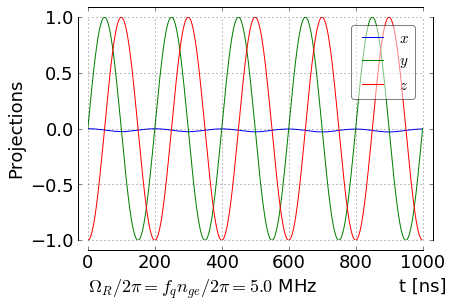

In [146]:
plt.plot(Ts, x_projection, label="$x$")
plt.plot(Ts, y_projection,label="$y$")
plt.plot(Ts, z_projection,label="$z$")
# plt.plot(Ts, x_projection_2D, "C0--",label="$x_{2l}$")
# plt.plot(Ts, y_projection_2D, "C1--",label="$y_{2l}$")
# plt.plot(Ts, z_projection_2D, "C2--",label="$z_{2l}$")

# plt.plot(Ts, z_projection_2D)
spines()
plt.legend(fancybox=True, framealpha=0.5, fontsize=15,ncol=1)
# plt.gca().set_yticklabels([])
plt.xlabel("t [ns]", position=(1,0))
plt.annotate("$\Omega_R/2\pi = f_q n_{ge}/2\pi = %.1f$ MHz"%(1e3*f_q_2D/2/pi), (0,0), xytext=(0,-.235), textcoords="axes fraction")
# plt.annotate("$\Omega_R/2\pi = %.1f$ MHz, $T_1$ = %.1f $\mu$s"%(1e3*f_q_2D/2/pi, 1/gamma/1e3), (0,0), xytext=(0,-.235), textcoords="axes fraction")

plt.ylabel("Projections")
plt.grid()
# plt.savefig("tr_xyz%.0f.pdf"%(1e3*f_q_2D/2/pi), bbox_inches="tight")
# plt.savefig("2d_rabi_example_pure.pdf", bbox_inches="tight")

NameError: name 'y_projection_2D' is not defined

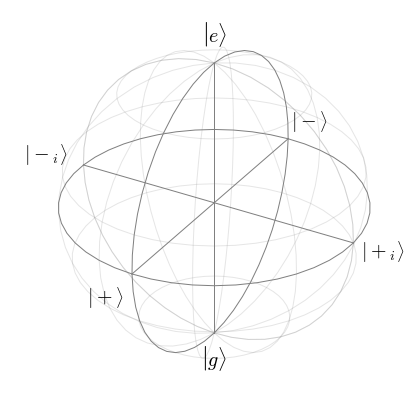

In [23]:
nrm=matplotlib.colors.Normalize(0,Ts[-1])
colors=cm.rainbow(nrm(Ts))

fig = plt.figure(figsize=(7,7))
axes = fig.add_axes([0.1, 0.2, 0.8, 0.8], projection="3d")
sph = Bloch(fig=fig, axes=axes)
sph.sphere_alpha = 0
sph.zlabel = [r'$\left|e\rightangle\right.$', r"$\left|g\rightangle\right.$"]
sph.xlpos = [1.3, -1.3]
sph.xlabel = [r'$\left.|+\right\rangle$', r"$\left.|-\right\rangle$"]
sph.ylpos = [1.2, -1.3]
sph.ylabel = [r'$\left.|+_i\right\rangle$', r"$\left.|-_i\right\rangle$"]
sph.xlpos = [1.3, -1.3]
sph.point_size=[40]
# axes.view_init(elev=10)

sph.point_color = list(colors)
sph.point_marker=['.']
# sph.add_points([x_projection, y_projection, z_projection], meth='m')
sph.render(fig, axes)
axes.scatter(y_projection_2D, -x_projection_2D, z_projection_2D,  edgecolors="none", c=list(colors))
m = cm.ScalarMappable(cmap=cm.viridis, norm=nrm)
m.set_array(Ts)
m.set_clim(0, Ts[-1])
position=fig.add_axes([0.2,0.2,0.63,0.035])
cb = fig.colorbar(m, orientation='horizontal', cax=position)
cb.set_label("Time, ns")
cb.set_ticks(np.linspace(0,round(Ts[-1]),6))
# plt.savefig("2d_rabi_example_bloch_pure_Y.pdf", bbox_inches="tight")

In [110]:
(evals[1]-evals[0])/2/pi

5.9917690531058927

In [75]:
c0s[-1], c1s[-1], c2s[-1]

(0.505767286293483, 0.4933904398324405, 0.0008419367687612302)

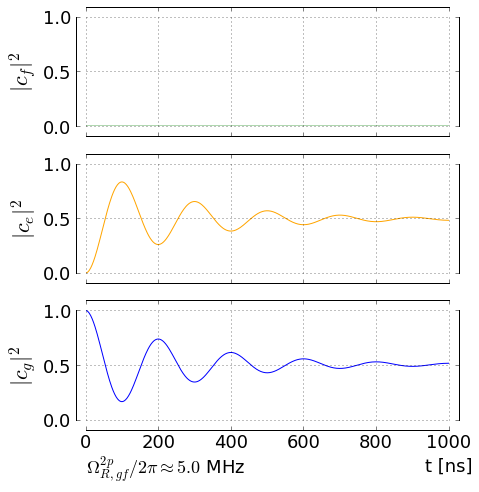

In [36]:
fig, axes = plt.subplots(nrows = 3, ncols=1, figsize=(7,7))

lines = [c0s, c1s, c2s, c3s]
colors = ["blue", "orange", "green", "red"]
state_letters = ["g", "e", "f", "d"]
for idx, cs, ax in zip(range(0, 4), lines, axes[::-1]):
    ax.plot(Ts, cs, color = colors[idx])
    spines(ax)
    ax.set_ylim(0, 1)
    ax.grid()
    ax.set_yticks((0,.5,1))
    ax.set_ylabel("$|c_%s|^2$"%state_letters[idx], fontsize=22)
    ax.set_xlim(0,1000)
    if idx > 0:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("t [ns]",position=(1,0))
        ax.annotate(r"$\Omega_{R, gf}^{2p}/2\pi \approx %.1f$ MHz"%(1e3*f_q_2D/2/pi), (0,0), xytext=(0,-.5), textcoords="axes fraction")
#         ax.annotate("$\Omega_R/2\pi = f_q n_{ge}/2\pi = %.1f$ MHz"%(1e3*f_q_2D/2/pi), (0,0), xytext=(0,-.8), textcoords="axes fraction")
plt.tight_layout()
# plt.savefig("tr_2p_%.0fMHz_dr.pdf"%(1e3*f_q_2D/2/pi), format="pdf", bbox_inches="tight")

(0, 15)

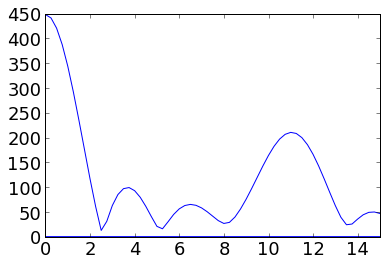

In [125]:
plot(fftfreq(int(1e4), Ts[1]-Ts[0])*1e3, abs(fft(c2s, n=int(1e4))))
plt.xlim(0,15)

In [109]:
1.5/Ts[array(c2s)>0.98]

array([ 0.01111647,  0.01108358,  0.00657237,  0.00656086])

In [198]:
ks = linspace(0.9, 1.1)

opts = Options(rhs_reuse=True, nsteps=1e4)
rhs_clear()

def parallel_task(omega):
    args = dict(omega=omega)
    T = 2*pi/omega
    U = propagator([H_q(), [n()*f_q, "sin(omega*t)"]], T, [gamma*c()], options=opts, args=args)
    return propagator_steadystate(U)

states = parallel_map(parallel_task, ks*(evals[1]-evals[0]), progress_bar=True, num_cpus=4)

10.0%. Run time:  40.77s. Est. time left: 00:00:06:06
20.0%. Run time:  59.85s. Est. time left: 00:00:03:59
30.0%. Run time:  80.49s. Est. time left: 00:00:03:07
40.0%. Run time: 101.30s. Est. time left: 00:00:02:31
50.0%. Run time: 135.51s. Est. time left: 00:00:02:15
60.0%. Run time: 154.38s. Est. time left: 00:00:01:42
70.0%. Run time: 172.58s. Est. time left: 00:00:01:13
80.0%. Run time: 192.72s. Est. time left: 00:00:00:48
90.0%. Run time: 225.42s. Est. time left: 00:00:00:25
100.0%. Run time: 238.45s. Est. time left: 00:00:00:00
Total run time: 238.51s


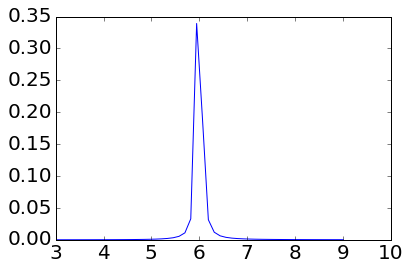

In [192]:
c0s = [abs((state.dag()*(evecs[1]*evecs[1].dag())).tr()) for state in states]
plt.plot(ks*(evals[1]-evals[0]), c0s)

## Two-photon analytics

In [38]:
n_fe_n_eg = n().matrix_element(evecs[2], evecs[1])*n().matrix_element(evecs[1], evecs[0])
w = (evals[2]-evals[0])/2
w_ge = evals[1]-evals[0]
w_rabi = f_q * n().matrix_element(evecs[0], evecs[1])
w_rabi_2p = (2*f_q**2/4*n_fe_n_eg/(w_ge - w))
w_rabi, w_rabi_2p

((0.0082871830524978863+0j), (-6.4466105714073972e-05+0j))

In [58]:
n().matrix_element(evecs[2], evecs[1])

(-1.8278880864589675+0j)

In [60]:
n().matrix_element(evecs[1], evecs[0])

(1.8652715292861246+0j)

In [67]:
pi**4+pi**5-np.e**6

-1.7673451168320753e-05